# Overview

## Description
Here we will train a Neural Network Model to predict if tweets are about real disasters or not.

# Necessary Imports

In [ ]:
# Import the libraries we'll use below.
from sklearn.model_selection import train_test_split # splits test/train data
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
import plotly.graph_objs as plotly  # for interactive plots
import tensorflow as tf
import re
import html
import string
import copy
from collections import defaultdict
sns.set(style="darkgrid")  # default style

# Setup & Baseline


## Installing Kaggle





Use *pip* to install Kaggle into the notebook.

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Setup Kaggle API

Upload your unique, Kaggle API Key. This can be retrieved by going into your Kaggle account settings.

In [ ]:
from google.colab import files
files.upload()

Make a directory to store our kaggle files.

In [ ]:
! mkdir ~/.kaggle

Copy the Kaggle API key into the directory made to store kaggle files.

In [ ]:
! cp kaggle.json ~/.kaggle/

Grant the necessary read/write permissons.

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

## Download the Datasets

Download the Twitter catastrophe datasets.

In [ ]:
! kaggle competitions download -c techexchange-2023-ml-project

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 55.4MB/s]


Unzip the dowloaded files.

In [ ]:
! unzip techexchange-2023-ml-project.zip

Archive:  techexchange-2023-ml-project.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Brief Data Analysis

In [ ]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
''' 
Taking a look at the first five values of the training data to get a sense of
what is inside the data set and get familiar with the formatting.
'''
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
''' 
Taking a look at the first five values of the test data to get a sense of
what is inside the data set and get familiar with the formatting.
'''
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Checking Shapes of Train & Test Data

In [ ]:
# Shape of the training Data 
print(f'The shape of the train data is: {train_data.shape}')

The shape of the train data is: (7613, 5)


In [ ]:
# Shape of the test Data 
print(f'The shape of the test data is: {test_data.shape}')

The shape of the test data is: (3263, 4)


### Statistical Summary of the Datasets

In [ ]:
# Summary of the training data
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [ ]:
# Sumary of the test data
test_data.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


## Checking for NaN Values 

Let's check how many entries are missing, that is, the number of *NaN* values per column.

In [ ]:
def print_nan_vals(df):
  for col in df:
    print(f'{col} contains {df[col].isna().sum()} missing values.')

Checking for missing values on the training data.

In [ ]:
print_nan_vals(train_data)

id contains 0 missing values.
keyword contains 61 missing values.
location contains 2533 missing values.
text contains 0 missing values.
target contains 0 missing values.


Checking for missing values on the test data. 

In [ ]:
print_nan_vals(test_data)

id contains 0 missing values.
keyword contains 26 missing values.
location contains 1105 missing values.
text contains 0 missing values.


## Cleaning our Data

Out of the given features, ID, keyword, location, and text, we only care about analyzing the text present within a tweet. The remaining features are very sparsely correlated, in other words, they don't have much bearing on the final classification of a tweet. 

From these features, only *keyword* and *location* have missing values. We can simply replace the missing values in the columns with hardcoded values, instead of erroneously assigning keywords or locations to certain tweets.

In the end, these are ways of filling in missing data entries without reducing the number of tweets we can work with. Since these features don't correlate well with the others, it shouldn't affect the accuracy of our model.

In [ ]:
def impute_tweets(df):
  to_fill = {'keyword': 'N/A', 'location': 'N/A'}
  df.fillna(value=to_fill, inplace=True)

Now, we can verify whether the missing values in these columns have been replaced or not. First, we impute the training data columns.

In [ ]:
# Verify whether the training tweets were correctly imputed
impute_tweets(train_data)
print_nan_vals(train_data)

id contains 0 missing values.
keyword contains 0 missing values.
location contains 0 missing values.
text contains 0 missing values.
target contains 0 missing values.


And then, we verify the test data columns.

In [ ]:
# Verify whether the test tweets were correctly imputed
impute_tweets(test_data)
print_nan_vals(test_data)

id contains 0 missing values.
keyword contains 0 missing values.
location contains 0 missing values.
text contains 0 missing values.


## Splitting our Data

In order to maintain the blindfulness of our testing data, we need to split our training data into training and validation data. A 90% of our data will become the training data for our model, and the remaining 10% will be used as validation data for our experiments.

It's worth noting that, in order to produce the same results each time, we need to pass a constant value to the parameter *random_state*. This is because scikit will randomly shuffle our dataframes each time we run our code. In including this parameter, we ensure consistently reproducible examples, in other words, the dataframes will always be shuffled in the same way.

In [ ]:
def split_train_data(df, train_size=0.9):
  train, test = train_test_split(df, 
                                 train_size=train_size, 
                                 random_state=1) # consistent results
  return train, test

Before splitting our data, it is worth noting that we need a set of features and a target to compare our results to. Our *X* values will become these set of features while our *Y* values will become the labels.

In [ ]:
# Split the training data set into X and Y values
X = train_data.loc[:, train_data.columns != 'target']
Y = train_data.loc[:, ['target']]

In [ ]:
# Split our X and Y values into training and validation data
X_train, X_test = split_train_data(X)
Y_train, Y_test = split_train_data(Y)

Let's now briefly check the shapes of our new data sets in order to confirm whether our data was correctly split or not.

In [ ]:
# New testing and training data shapes
print(f'The new shape of the X-train data is: {X_train.shape}')
print(f'The new shape of the Y-train data is: {Y_train.shape}')

The new shape of the X-train data is: (6851, 4)
The new shape of the Y-train data is: (6851, 1)


In [ ]:
# Shape of the test data 
print(f'The new shape of the X-test data is: {X_test.shape}')
print(f'The new shape of the Y-test data is: {Y_test.shape}')

The new shape of the X-test data is: (762, 4)
The new shape of the Y-test data is: (762, 1)


## Computing the Baseline

Let's construct a baseline that utilizes the majority class in the training data as the label we'll be comparing our predictions to.

In [ ]:
def baseline(train):
  # Get the sizes for each class
  positive_size = train['target'].value_counts()[1]
  negative_size = train['target'].value_counts()[0]
  # Return majority class 
  return 1 if positive_size > negative_size else 0

In [ ]:
# Compute baseline on our training data labels 
base = baseline(Y_train)
print(f"The majority class is: {'negative' if not base else 'positive'}")

The majority class is: negative


The computed majority class is the negative class, all entries with a label of 0. We can now use our validation set to measure the baseline's accuracy by calculating its F1 score: 2 times the product of the precision and recall over their sum. 

In [ ]:
def get_evaluation_metrics(actual_outputs, predicted_outputs):
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(predicted_outputs)):
      if (predicted_outputs[i] == 1) and (actual_outputs[i] == 1):
        tp += 1
      elif (predicted_outputs[i] == 0) and (actual_outputs[i] == 0):
        tn += 1
      elif (predicted_outputs[i] == 1) and (actual_outputs[i] == 0):
        fp += 1
      else:
        fn += 1
    return tp,tn,fp,fn

In [ ]:
def recall(tp, fn):
  if tp + fn == 0:
    return 0
  return  tp / (tp + fn)

In [ ]:
def precision(tp, fp):
  if tp + fp == 0:
    return 0
  return tp / (tp + fp)

In [ ]:
def f1_score(true_output, predicted_output):
  tp, tn, fp, fn = get_evaluation_metrics(true_output, predicted_output)
  p, r = precision(tp, fp), recall(tp, fn)
  if p+r == 0:
    return 0
  
  return 2 * ((p * r) / (p + r))   

In [ ]:
baseline_preds = [0] * Y_test.size # baseline predictions are all 0
score = f1_score(np.array(Y_test['target']), baseline_preds)
print(f"The F1 score on the validation set with respect to the baseline: \
{score}")

The F1 score on the validation set with respect to the baseline: 0


Thus, our computed F1 score is 0. This occurs because, since the majority class is our negative class, then all of our predictions are 0. Therefore, there are no true positive or false positive examples, making both the precision and the recall 0.


## Submitting our Baseline Results

Now that the baseline has established the majority class, we can write our results to a CSV file and submit these preliminary predictions. 

In [ ]:
# It's easier to store each ID and its prediction in a dict
base_predictions = {'id': [], 'target': []}
for id in test_data['id']:
  base_predictions['id'].append(id)
  base_predictions['target'].append(0) # each prediction is the negative class
  
# Convert dict to dataframe to facilitate writing to a CSV
base_df = pd.DataFrame(base_predictions)
base_df.to_csv('baseline.csv', index=False) # don't include DF index column

With our CSV file in hand, we can now submit our predictions to Kaggle. The code below utilizes Colab's kernel to upload our baseline CSV to Kaggle, which then scores the submission.

In [ ]:
# ! kaggle competitions submit techexchange-2023-ml-project -f ./baseline.csv -m "Yariel & Yan's baseline"

Below is a table with the different models used throughout the project and their scores. 

| Model | F1 (Validation)  | Kaggle Score |  
|-------|-----|--------------|
| Baseline| 0  | 0.57033|


# Data Analysis

## Classifying Keywords

We can begin our data analysis of the keywords by counting how many times each keyword appears in a Tweet classified as a natural disaster, our positive class, and how many times that keyword appears in a Tweet not classified as a natural disaster, our negative class. We will handpick some of the more telling keywords.

In [ ]:
keywords = ['ablaze', 'arson', 'blizzard', 'devastated', 'famine', 
          'screaming', 'rioting', 'tsunami', 'twister']

table = {'Keywords': keywords, 
         'Positive': [0 for _ in range(len(keywords))], 
         'Negative': [0 for _ in range(len(keywords))]}

target = Y_train['target']
for key_idx, keyword in enumerate(keywords):
  # for each keyword, get indeces for where they appear in the train df
  train_idx = X_train.loc[X_train['keyword'] == keyword].index.tolist()
  # add to table accordingly
  for idx in train_idx:  
    if target[idx]: 
      table['Positive'][key_idx] += 1

    else: 
      table['Negative'][key_idx] += 1

# Construct table from a dict -> dataframe
df = pd.DataFrame.from_dict(table)
print(df.to_string(index=False))

  Keywords  Positive  Negative
    ablaze        13        21
     arson        20        10
  blizzard         4        30
devastated        18        10
    famine        25        13
 screaming         2        29
   rioting        23        10
   tsunami         9        21
   twister         5        31


From the frequency table, nouns and verbs like "arson", "rioting", and "famine" are more often correlated with disasters, since these leave little room for word play, while other adjectives or more general verbs like "blizzard" and "screaming" can be utilized in contexts outside of natural disasters. To elaborate on this, the word "screaming" can be used for just about any situation expressing excitement while "blizzard" has a wider variety of meanings. We can examine some examples of this below. 

In [ ]:
display(X_train.loc[X_train['keyword'] == "screaming"][:5])

,id,keyword,location,text
5947,8496,screaming,N/A,If you are quiet enough you can literally hear...
5966,8517,screaming,Namjoon's pants,'[+54 -9] How do people not know who Kendall J...
5953,8504,screaming,tx,@camilacabello97 NOW IM INTERNALLY SCREAMING
5968,8520,screaming,All around the world,@ArianaGrande @justinbieber I'M SCREAMING OMG ...
5948,8497,screaming,"21, Porto",I'M SCREAMING AND FANGIRLING OH MY GOD https:...


In [ ]:
display(X_train.loc[X_train['keyword'] == "blizzard"][:5])

,id,keyword,location,text
822,1196,blizzard,N/A,@blizzard_fans Lucio!! Let's get the #overwatc...
840,1219,blizzard,Ontario Canada,@TCGReno just hard reset my Xbox
820,1191,blizzard,N/A,Stats http://t.co/U7vavyrGv9
846,1226,blizzard,N/A,Someone walk with me to DQ ??\nI wanna Butterf...
839,1218,blizzard,N/A,I love the cotton candy blizzard??


##Tweet Lengths

We will now proceed to count the length of the Tweets to see if it's necessary to truncate them, and if so, what length covers most of the data in order to truncate as few Tweets as possible, to preserve our data.

In [ ]:
# Here we map the words to their frequency 
# We use a defultdict in order to give a default value rather than an error
# when a word is seen for the first time
tweet_lengths = defaultdict(int)
for tweet in X_train['text']:
  tweet_lengths[len(tweet)] += 1
lengths = tweet_lengths.keys()
frequencies = tweet_lengths.values()

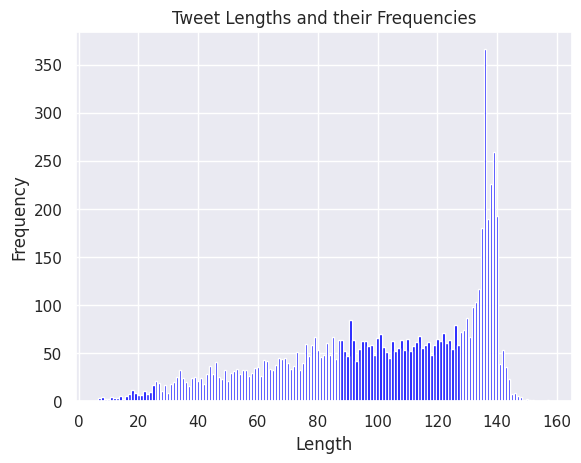

In [ ]:
# Let's use a bar plot 
# The histogram function can take a list of inputs and corresponding labels.
plt.bar(lengths, frequencies, color='blue')
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Tweet Lengths and their Frequencies")
plt.show() 

In this case we can observe that Tweet sizes are relative small. This is due to the fact that Twitter has a limit of 280 characters per Tweet. Therefore, there is no need to truncate any of the Tweets.


Now that we decided that there's no real benefit to truncate the Tweets, let's try to see if there is a noticeable difference between the lengths of the Tweets in the positive and the negative classes.

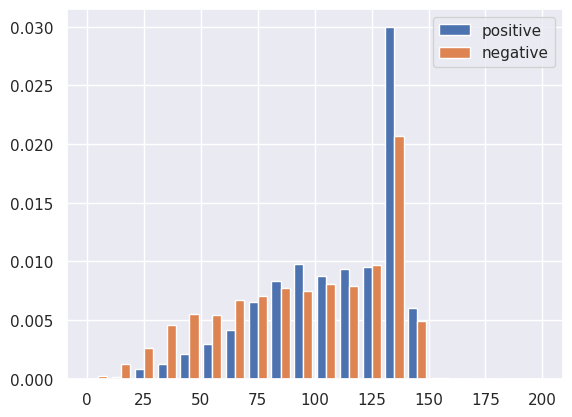

Longest positive Tweet: 151
Longest negative Tweet: 157


In [ ]:
# Turn dataframes -> lists  
X = X_train['text'].tolist()
Y = Y_train['target'].tolist()

# Create a list of lengths for training examples with a positive label.
text_lengths_pos = [len(x) for (i, x) in enumerate(X) if Y[i]]

# And a list of lengths for training examples with a negative label.
text_lengths_neg = [len(x) for (i, x) in enumerate(X) if not Y[i]]

# The histogram function can take a list of inputs and corresponding labels.
plt.hist([text_lengths_pos, text_lengths_neg], bins=20, range=(0, 200),
         label=['positive', 'negative'], density=True)

plt.legend()
plt.show()
# Also check the longest Tweets from each class.
print('Longest positive Tweet:', max(text_lengths_pos))
print('Longest negative Tweet:', max(text_lengths_neg))

On average, Tweets not classified as being related to natural disasters tend to have longer lengths. This is due in part to these Tweets talking about other random topics, while Tweets about natural disasters tend to be more concise and constrained towards just reporting the incident.

## Analyzing Our Vocabulary

We will map the words present within Tweets to their frequencies in order to  get a sense of how many unique words we have. We will also plot the top words in our vocabulary to check for correlations between our positive and negative classifications, and whether it can help us in reducing our vocabulary size.

In [ ]:
# Go through each word in each tweet to help build our vocabulary
vocab = defaultdict(int)
for tweet in X_train['text']:
  for word in tweet.split(' '):
    vocab[word] += 1

print('There are', len(vocab), 'words in our vocabulary.')

There are 29659 words in our vocabulary.


In [ ]:
# Find the top k most frequent words 
def k_most_frequent_words(data, iterations):
  words, frequencies = [], []
  copy_data = copy.deepcopy(data)
  for i in range(iterations):
    word = max(copy_data, key=data.get)  
    frequency = copy_data[word]
    words.append(word)
    frequencies.append(frequency)
    copy_data.pop(word)
  return words, frequencies

In [ ]:
# Make a bar plot of the most frequent words
def plot_most_frequent_words(data, quantity, width, heigth):
  words, frequencies = k_most_frequent_words(data, quantity)
  plt.figure(figsize=(width, heigth))
  plt.bar(words, frequencies, color='blue')
  plt.xlabel("Words")
  plt.ylabel("Frequencies")
  plt.title("Top K Words and their Frequencies")
  plt.show()

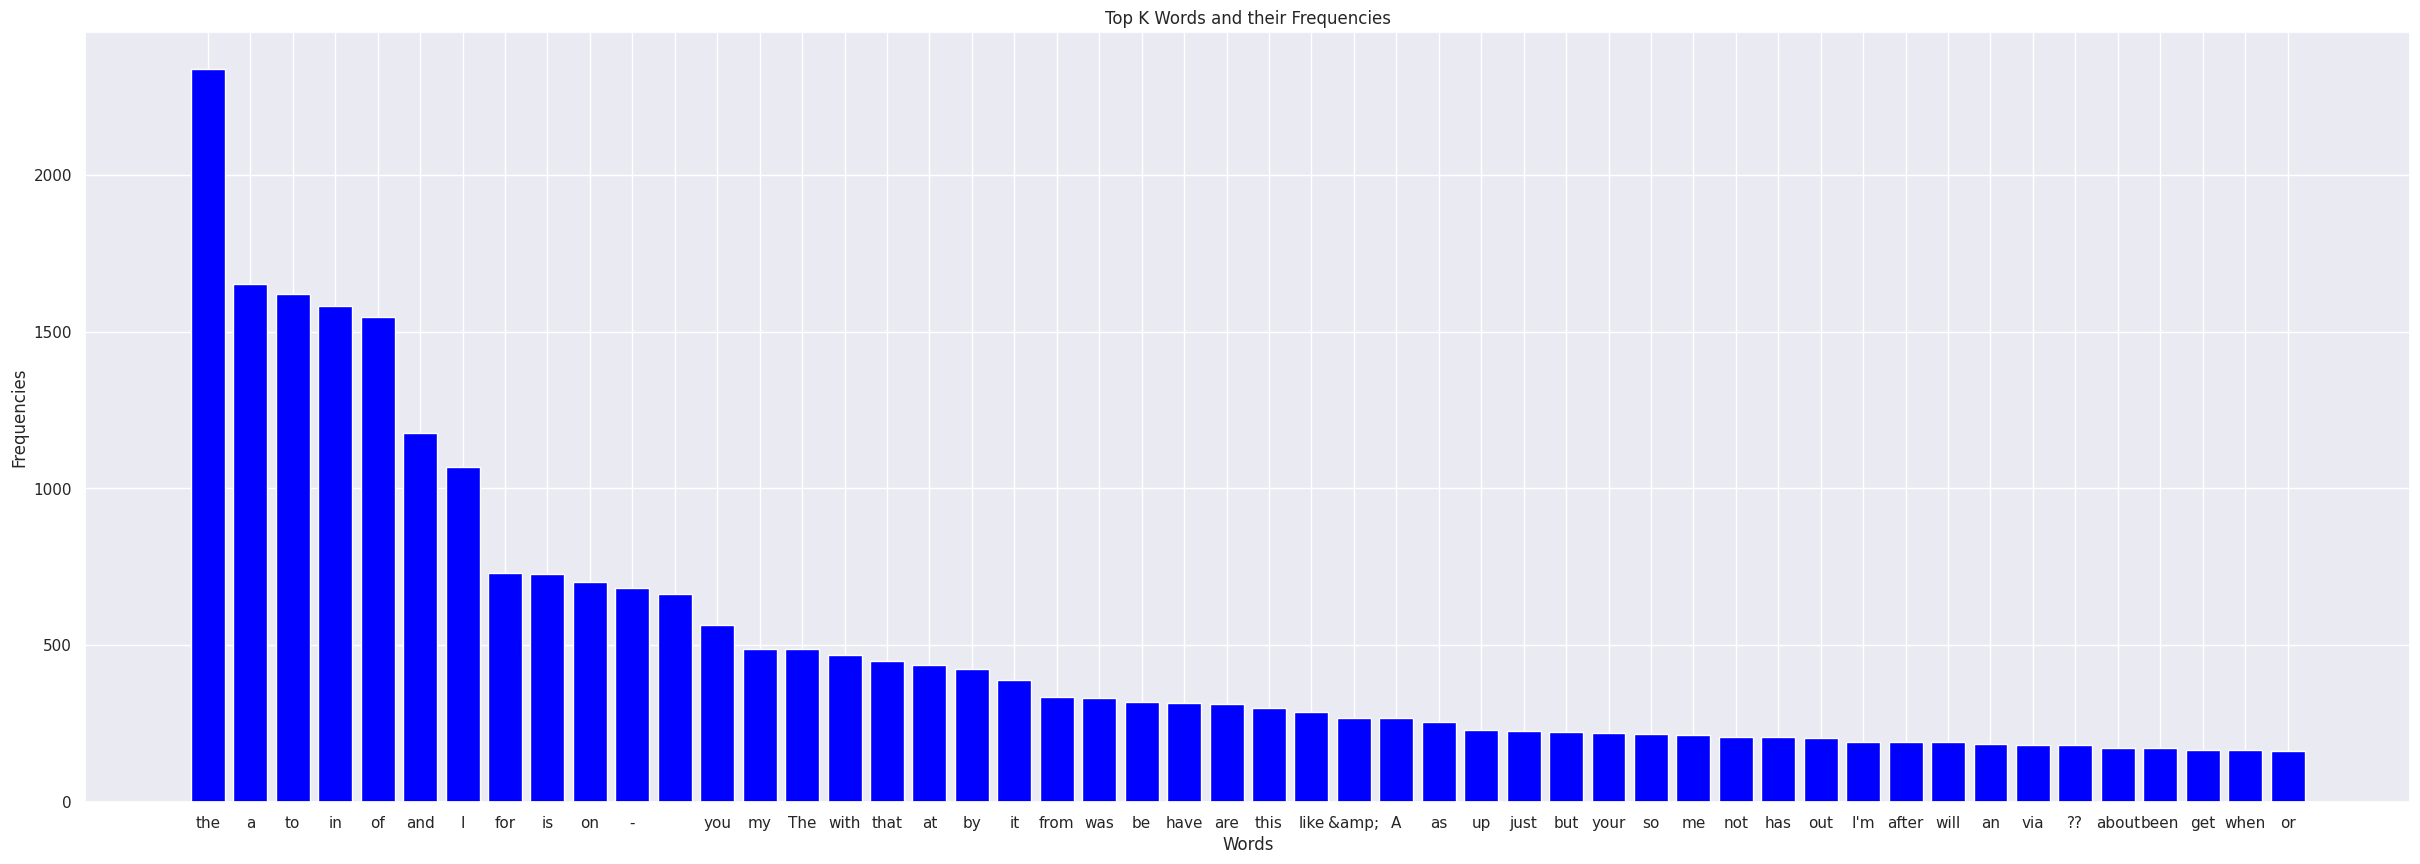

In [ ]:
plot_most_frequent_words(vocab, quantity=50, width=30, heigth=10)

From the plot, we can observe that the top 50 words don't really give any indication towards either class as most words are either articles or pronouns. Additionally, there are some special characters which don't really convey meaning such as "??" or ";amp;". We can apply these observations later on when deciding on how to reduce our vocabulary.

# Building Our Vocabulary 

## Constructing & Encoding

The vocabulary we constructed during our data analysis maps words to their frequency, however, our models will only process numbers. When trying to encode the words, there is a possibility that the words that have the same frequency are in the same tweet, therefore, when we encode our text, words with the same frequency will be mapped to the same ID despite being different words. In the example below, we can examine a couple of examples of words with identical frequencies.

In [ ]:
# Let's sort our vocabulary by the values in descending order
sorted_vocab = sorted(vocab.items(), key=lambda x:x[1], reverse=True)
print(sorted_vocab)

In [ ]:
# Let's see an example of words that have the same frequency
print("'We' repeats", sorted_vocab[114][1], "times")
print("'In' repeats", sorted_vocab[115][1], "times")

'We' repeats 67 times
'In' repeats 67 times


We can fix this problem by creating a new vocabulary that maps words to a new ID. However, before we tackle this problem, we should first focus on sanitizing our text. 

Since each Tweet was scraped off of Twitter, many of them contain HTML entities and other unwanted characters within the final text. Our goal will be to strip and reduce each Tweet to a vocabulary as close to basic English as possible, which will make it easier to encode and feed that vocabulary into our model. By reducing the noise and keeping only relevant data, our model will generalize better. The code below explains in detail what parts of the Tweets are relevant to our model and what parts have to be removed.



In [ ]:
# Helps us replace special characters with English equivalents
! pip install unidecode

import nltk
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from unidecode import unidecode
from nltk.corpus import stopwords
def sanitize_text(tweet):
  """Cleans up each word in our Tweets in order
  to maximize our vocabulary and improve results."""
  # Don't treat words such as A and a differently
  tweet = tweet.lower()  
  # Not parsing links, replace with spaces
  tweet = re.sub(r'http\S+', ' ', tweet)  
  # Remove hashtags but keep the words 
  # Also split the hashtags in case they're chained
  # (Ex. #word1#word2)
  tweet = tweet.replace("#", " ")
  # Remove account mentions, tell us nothing
  # about the final classification
  tweet = re.sub("@[A-Za-z0-9]+","", tweet)
  # Replace characters like ÛÏ
  tweet = unidecode(tweet)
  # Unescape HTML entities (ex. &gt;)
  tweet = html.unescape(tweet)
  # Not parsing numbers
  tweet = re.sub('[0-9]', '', tweet)
  # Remove all leftover punctuation
  tweet = tweet.translate(str.maketrans('', '', string.punctuation))
  # Short words are often "garbage"/leftover characters
  # or don't mean anything
  cleaned_tweet = [word for word in tweet.split() if len(word) > 2 
                   and word not in stopwords.words('english')]
  cleaned_tweet = ' '.join(cleaned_tweet)
  # Remove consecutive spaces 
  cleaned_tweet = re.sub(' +', ' ', cleaned_tweet)
  return cleaned_tweet

In [ ]:
# Test our pre processing function
examples = [X[70], X[65], X[234]]
for s in examples:
  print(f"Original tweet: {s}")
  print(f"Sanitized tweet: {sanitize_text(s)}\n")

Original tweet: Malaysian Officials Say Debris Found on Reunion Island Is From #MH370. @BillNeelyNBC reports: http://t.co/r6kZSQDghZ
Sanitized tweet: malaysian officials say debris found reunion island reports

Original tweet: The Sinking Ship (@sinkingshipindy): Scarlet Lane Lenore  is on replacing Stone Saison (@StoneBrewingCo)
Sanitized tweet: sinking ship scarlet lane lenore replacing stone saison

Original tweet: @TfLBusAlerts @TfLBusAlerts The Drive in Ilford closed both ways while emergency services deal with a call out. Buses are now stuck.
Sanitized tweet: drive ilford closed ways emergency services deal call buses stuck



Now that we've tested our function to clean up text, we can apply it to the entire data set before encoding it. We will encode the text, in order for our models to understand it, by mapping each word to a unique ID that increases every time we encounter a word.

In [ ]:
# Clean our training data
X_train_sanitized = X_train['text'].apply(lambda x: sanitize_text(x))
# Verify it was sanitized
print(f"Original text: {X_train['text'][0]}")
print(f"Cleaned text: {X_train_sanitized[0]}")

Original text: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned text: deeds reason earthquake may allah forgive


In [ ]:
# We start from 1 to reserve space for OOV words
new_vocab = dict()
id = 1
OOV = 0
# Sort the old vocab by frequency
old_vocab = defaultdict(int)
for tweet in X_train_sanitized:
  for word in tweet.split():
    old_vocab[word] += 1

# Map by ID each time a word is found and display them
sorted_old_vocab = sorted(old_vocab.items(), key=lambda x:x[1], reverse=True)
for word, freq in sorted_old_vocab:
  new_vocab[word] = id
  id += 1

#sorted_new_vocab = sorted(new_vocab.items(), key=lambda x:x[1])
print(new_vocab)
print(f"The cleaned vocab is {len(new_vocab)} words long")

In [ ]:
# Keep track of what ID each word maps to
# Let's reserve * for OOV 
encode_to_words = dict([(val, key) for (key, val) in new_vocab.items()])
encode_to_words[0] = '*'
print(encode_to_words)

In [ ]:
# Encodes tweets using our vocabulary so we can use them in our models 
def encode(text):
  result = []
  text = sanitize_text(text)
  # We know what this word encodes to
  for word in text.split():
    if word in new_vocab:
      result.append(new_vocab[word])
    # OOV
    else:
      result.append(OOV)
  return np.array(result)  # for model processing

Let's now make a decoding function, to retrieve the original text from an encoded array, and test to ensure that the encoding works as expected.

In [ ]:
# Decodes our vocabulary
def decode(word_array):
  result = []
  for code in word_array:
    result.append(encode_to_words[code])
  return ' '.join(result)

In [ ]:
# Example of our encoding/decoding functions
text = X[10]
encoded_text = encode(text)
print(f"Old vocab: {text}")
print(f"New vocab: {encoded_text}")
print(f"Decoded vocab: {decode(encoded_text)}") 

Old vocab: Indeed!! I am fully aware of that battle! I support you in that fight!!  https://t.co/MctJnZX4H8
New vocab: [1381 1074 1927  257  506  484]
Decoded vocab: indeed fully aware battle support fight


Now that we've tested that we can encode and decode text appropriately, we can encode the entire training set and utilize that for our models.

In [ ]:
def encode_data(data):
  encoded = []
  for tweet in data:
    encoded.append(encode(tweet))
  return np.array(encoded, dtype=object)

In [ ]:
# Encoding all of our training data
X_train_encoded = encode_data(X_train['text'])
print(len(X_train))
print(len(X_train_encoded))

6851
6851


## Padding & Limiting our Data

In order to fit the data to our model and for our neural network inputs to be roughly the same size, we need to pad our text such that each Tweet has the same length. Given that the length of our longest Tweet in the training set was 157 words long, we can safely pad all of our Tweets to a maximum length of 160 words.

In [ ]:
def pad_data(tweets, max_length=160):
  # Model can only process numpy arrays
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          tweets, maxlen=max_length, padding='post', value=0)))

X_train_padded = pad_data(X_train_encoded)
print(X_train_padded[0].size)

160


After padding the data, we will limit our vocabulary size to facilitate training on our data and cut down on processing time.

In [ ]:
def limit_vocab(sequences, max_token_id=2000, oov_id=0):
  """Reduces number of tokens in our vocabulary by setting everything greater 
  the number of tokens we want to our OOV ID."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

X_train_reduced = limit_vocab(X_train_padded)
# Compare results
print(f"Original vocabulary: {X[0]}")
print(f"Padded/reduced vocabulary: {decode(X_train_reduced[0])}\n")

print(f"Original vocabulary: {X[69]}")
print(f"Padded/reduced vocabulary: {decode(X_train_reduced[69])}")

Original vocabulary: Our builder is having a dental emergency. Which has ruined my plan to emotionally blackmail him this afternoon with my bump.
Padded/reduced vocabulary: * * emergency * plan * * afternoon * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

Original vocabulary: Tube strike live: Latest travel updates as London is engulfed in chaos: Û_  cross-London travel will be accepte...  http://t.co/vg8HRbebdA
Padded/reduced vocabulary: tube strike live latest travel updates london engulfed * * travel * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

Before continuing on to build and experiment with our model, we must pad and limit the test data in the same way. 

In [ ]:
X_test_padded = pad_data(encode_data(X_test['text']))
X_test_reduced = limit_vocab(X_test_padded)

# Building Our Models

## FFNN Binary Classifier: V1

Our initial model will be a Feed Forward Neural Network text classifier. We will create an embedding and output layer along with additional, ReLU activation hidden layers to handle intermediate computations and improve our accuracy. Averaging our data will also result in more accurate predictions and will avoid overfitting. Since we are dealing with a binary classification problem, we will utilize a sigmoid activation function along with a binary cross entropy loss function for our model, which we'll be calling *V1*.

In [ ]:
vocab_length = 10000
embed_dim = 128

def build_embeddings_model(vocab_size=vocab_length,   # Vocab size
                            sequence_length=160,      # Tweet length
                            embedding_dim=embed_dim): # Embedding dim size
    """Build a TF model using embeddings"""
    # Consistent results
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(0)

    model = tf.keras.Sequential()
    # Input/Embedding layer
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length)
    )

    # Average our data
    model.add(tf.keras.layers.GlobalAveragePooling1D()) 

    # Hidden layers
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))

    # Output layer
    model.add(tf.keras.layers.Dense(
        units=1,                     # output dim (for binary classification)
        activation='sigmoid'         
    ))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Let's now train this model with our training data and see how it performs. We'll be utilizing a batch size of 64 and a 10% of our examples for validation. Additionally, we'll plot how the loss reduces throughout the epochs to have an indication of whether our data is being overfit/underfit or not and if so, adjust our model's parameters accordingly.

In [ ]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

V1 Training Results
-------------------
Epoch 1/5
97/97 [==============================] - 5s 28ms/step - loss: 0.6837 - accuracy: 0.5648 - val_loss: 0.6811 - val_accuracy: 0.5714
Epoch 2/5
97/97 [==============================] - 2s 23ms/step - loss: 0.6763 - accuracy: 0.5697 - val_loss: 0.6566 - val_accuracy: 0.5714
Epoch 3/5
97/97 [==============================] - 2s 22ms/step - loss: 0.5382 - accuracy: 0.7338 - val_loss: 0.4698 - val_accuracy: 0.8090
Epoch 4/5
97/97 [==============================] - 2s 24ms/step - loss: 0.3906 - accuracy: 0.8316 - val_loss: 0.4655 - val_accuracy: 0.8061
Epoch 5/5
97/97 [==============================] - 3s 32ms/step - loss: 0.3575 - accuracy: 0.8467 - val_loss: 0.4731 - val_accuracy: 0.8032


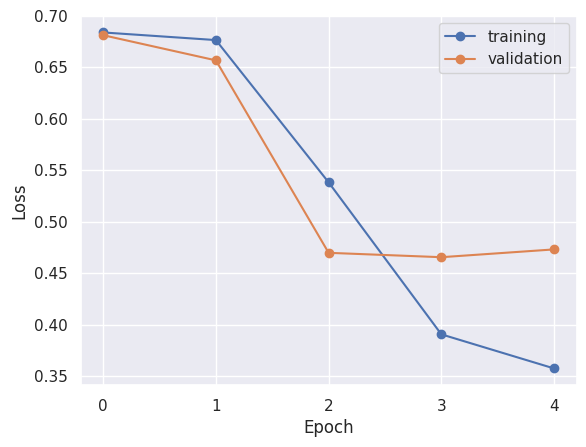

In [ ]:
def train_V1():
  ffnn_model = build_embeddings_model()
  print("V1 Training Results\n-------------------")
  history = ffnn_model.fit(
    x = X_train_reduced,   # Padded training data
    y = Y_train,          # Binary labels
    epochs=5,             
    batch_size=64,        # mini-batch size
    validation_split=0.1, # use a fraction of the examples for validation
    verbose=1             # display some progress output during training
  )
  # Plot training attempt
  history = pd.DataFrame(history.history)
  plot_history(history)
  return ffnn_model

ffnn_model = train_V1()

V1 produces a validation accuracy of about 80% without severely underfitting the data, a good result for this model. We can now calculate the F1 score and submit the predictions for V1.

We'll begin by calculating the F1 score on the validation data by producing our predictions for that data set. The first two functions below will be handling all of the predictions for us for the given model and test sets.

In [ ]:
def produce_binary_predictions(predictions):
  """Takes in the probabilities generated by TF's predictions
  and assigns those to the positive or negative classes."""
  for i, pred in enumerate(predictions):
    # Assign to the negative class
    if pred < 0.5:
      predictions[i] = 0
    # >= 0.5, more than half chance it's of the positive class
    else:
      predictions[i] = 1

In [ ]:
def make_model_predictions(model, test_data):
  """Returns an array of the final predictions
  for a given model."""
  preds = model.predict(test_data)
  produce_binary_predictions(preds)
  return preds.flatten().astype(int)

In [ ]:
# Make predictions on the validation data
v1_val_preds = make_model_predictions(ffnn_model, X_test_reduced)
# Compute the F1 score.
v1_val_score = f1_score(np.array(Y_test['target']), v1_val_preds)
print(f"The F1 score, on the validation set, for V1: {v1_val_score}")

24/24 [==============================] - 0s 3ms/step
The F1 score, on the validation set, for V1: 0.7606112054329371


Now that we've calculated the F1 score and obtained a satisfactory result, we can run the model on our blind test data.

In [ ]:
# Pad and limit our actual test data
test_padded = pad_data(encode_data(test_data['text']))
test_reduced = limit_vocab(test_padded)
# Make the predictions
v1_predictions = make_model_predictions(ffnn_model, test_reduced)

102/102 [==============================] - 0s 2ms/step


Given how padding and limiting data doesn't change its order around, we can write our results to our final CSV in the same order.

In [ ]:
def create_predictions_csv(predictions, filename):
  """Creates a CSV with the given predictions,
  from the testing data set, and saves it."""
  data_dict = {'id': [], 'target': []}
  for i, id in enumerate(test_data['id']):
    # Write our predictions
    data_dict['id'].append(id)
    data_dict['target'].append(predictions[i])

  # Convert dict to dataframe to facilitate writing to a CSV
  df = pd.DataFrame(data_dict)
  df.to_csv(f'{filename}', index=False) 

In [ ]:
create_predictions_csv(v1_predictions, 'v1.csv')

We can now submit our *V1* model's predictions to Kaggle and jot down its score. The table below summarizes how this model performed.

In [ ]:
# ! kaggle competitions submit techexchange-2023-ml-project -f ./v1.csv -m "Model V1 Predictions"

100% 22.2k/22.2k [00:00<00:00, 106kB/s]
Successfully submitted to TechExchange 2023 ML Project

| Model | F1 (Validation)  | Kaggle Score |  
|-------|-----|--------------|
| Baseline| 0  | 0.57033|
| V1|  0.75376  | 0.78700 |

## CNN Binary Classifier: V2

Despite our FFNN being a good enough classifier, we will attempt to improve our loss and accuracy by entirely changing our model architecture to a Convolutional Neural Network. When implemented correctly, the filters in a CNN can help identify patterns or sentiments within our text regardless of word order in the sentence. Since CNNs analyze each word independently, it can help identify correlations between keywords in a Tweet and its final classification. 

This next model will be reffered to as *V2* and will have similar parameters and activation functions as V1, but with convolutional layers instead of hidden layers.

In [ ]:
vocab_length = 10000
embed_dim = 8

def build_CNN_model(vocab_size=vocab_length,  # Vocab size
                    sequence_length=160,      # Tweet length
                    embedding_dim=embed_dim): # Embedding dim size
    """Builds a TF model utilizing convolutional layers."""
    # Consistent results
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(0)

    # Input layer
    x = tf.keras.Input(shape=(sequence_length))                         
    
    # Embedding layer 
    tweet_emb = tf.keras.layers.Embedding(input_dim=vocab_size,
                                          output_dim=embedding_dim,
                                          input_length=sequence_length)(x)

    # Convolutional filters of increasing sliding window sizes
    c1 = tf.keras.layers.Conv1D(
        filters=32, kernel_size=4, padding='same', activation='relu')(tweet_emb)

    c2 = tf.keras.layers.Conv1D(
        filters=32, kernel_size=5, padding='same', activation='relu')(tweet_emb)

    c3 = tf.keras.layers.Conv1D(
        filters=32, kernel_size=6, padding='same', activation='relu')(tweet_emb)

    c4 = tf.keras.layers.Conv1D(
        filters=32, kernel_size=7, padding='same', activation='relu')(tweet_emb)

    # Concatenate feature maps, get max value with max-pool, 
    # and flatten into a vector
    y = tf.keras.layers.Concatenate()([c1, c2, c3, c4])
    y = tf.keras.layers.Dropout(rate=0.05)(y)  # Minimize overfitting
    y = tf.keras.layers.MaxPool1D(pool_size=sequence_length)(y)
    y = tf.keras.layers.Flatten()(y)

    # Dense layer 
    y = tf.keras.layers.Dense(units=embedding_dim, activation='relu')(y)

    # Output layer
    y = tf.keras.layers.Dense(units=1, activation='sigmoid')(y)

    # Compile our model 
    model = tf.keras.Model(inputs=x, outputs=y)
    model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    return model

With our CNN model constructed, let's observe how it performs during training in order to adjust to model to account for underfitting.

V2 Training Results
-------------------
Epoch 1/4
97/97 [==============================] - 13s 109ms/step - loss: 0.6656 - accuracy: 0.6024 - val_loss: 0.5975 - val_accuracy: 0.7230
Epoch 2/4
97/97 [==============================] - 7s 70ms/step - loss: 0.4603 - accuracy: 0.8036 - val_loss: 0.4431 - val_accuracy: 0.8163
Epoch 3/4
97/97 [==============================] - 5s 55ms/step - loss: 0.3534 - accuracy: 0.8503 - val_loss: 0.4524 - val_accuracy: 0.8076
Epoch 4/4
97/97 [==============================] - 6s 63ms/step - loss: 0.3139 - accuracy: 0.8720 - val_loss: 0.4759 - val_accuracy: 0.7974


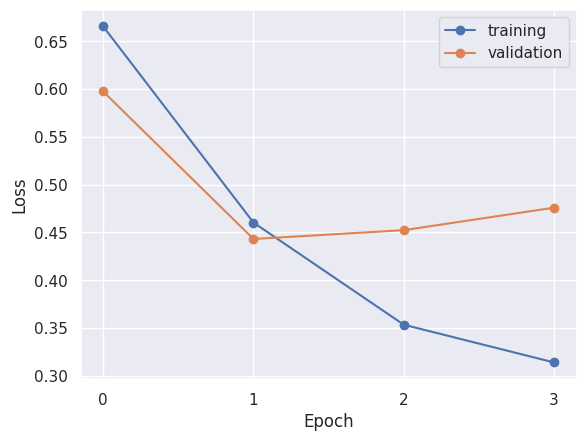

In [ ]:
def train_V2():
  cnn_model = build_CNN_model()
  print("V2 Training Results\n-------------------")
  history = cnn_model.fit( 
    x = X_train_reduced, 
    y = Y_train,                   
    epochs=4, # the extra epochs offer no improvements        
    batch_size=64,        
    validation_split=0.1, 
    verbose=1)

  # Plot training attempt
  history = pd.DataFrame(history.history)
  plot_history(history)
  return cnn_model

cnn_model = train_V2()

V2 produces a final validation loss and accuracy of 0.4759 and 0.7974 respectively, no improvement at all during training compared to V1, which featured a validation loss and accuracy of 0.4725 and 0.7959. Let's continue seeing how the CNN compares by calculating its F1 score and submitting our predictions.

In [ ]:
# Make predictions on the validation data
v2_val_preds = make_model_predictions(cnn_model, X_test_reduced)
# Compute the F1 score.
v2_val_score = f1_score(np.array(Y_test['target']), v2_val_preds)
print(f"The F1 score, on the validation set, for V2: {v2_val_score}")

24/24 [==============================] - 0s 11ms/step
The F1 score, on the validation set, for V2: 0.7581903276131045


In [ ]:
# Make the predictions on the blind test data
v2_predictions = make_model_predictions(cnn_model, test_reduced)
create_predictions_csv(v2_predictions, 'v2.csv')

102/102 [==============================] - 1s 6ms/step


In [ ]:
# ! kaggle competitions submit techexchange-2023-ml-project -f ./v2.csv -m "Model V2 Predictions"

100% 22.2k/22.2k [00:00<00:00, 109kB/s]
Successfully submitted to TechExchange 2023 ML Project

Our performance table, now including all 3 models developed thus far, is included below.

| Model | F1 (Validation)  | Kaggle Score |  
|-------|-----|--------------|
| Baseline| 0  | 0.57033|
| V1|  0.75376  | 0.78700 |
| V2|  0.75819  | 0.77842 |

Observing that V2 scored a slightly better F1 score but performed worse than V1 in all other aspects, it can be concluded that this model is not generalizing well. It is likely memorizing data rather than learning correlations between words and whether something is a natural disaster. This is backed by the fact that CNNs work best with larger training sets or other data types that simpler architectures struggle with, such as image classification. 

Attempting to improve V2 by tweaking the parameters led to diminishing improvements, meaning that the problem with the model is likely the type of architecture being utilized. In conclusion, FFNN models are more efficient at handling non linear data while being better suited towards text classification problems than CNNs.

# Final Analysis: Comparing Results



## Evaluating Model Performance

### Examining Confusion Matrices

Now that we've concluded training and building our models, let's evaluate our best model's performance, V1, by examining its confusion matrix.

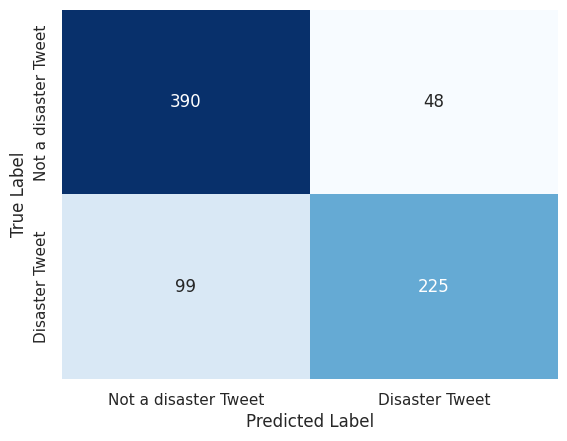

In [ ]:
# Create confusion matrix by examining V1's predictions vs the actual values
v1_confusion_matrix = tf.math.confusion_matrix(Y_test, v1_val_preds)
labels = ['Not a disaster Tweet', 'Disaster Tweet']

# Use a heatmap plot to display it.
ax = sns.heatmap(v1_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=labels, yticklabels=labels, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

From the confusion matrix above, we can observe that most tweets were classified as either true positives or true negatives, with the smallest category being false negative classifications. We can compare how V1 stacked against V2 by taking the difference of their confusion matrices.

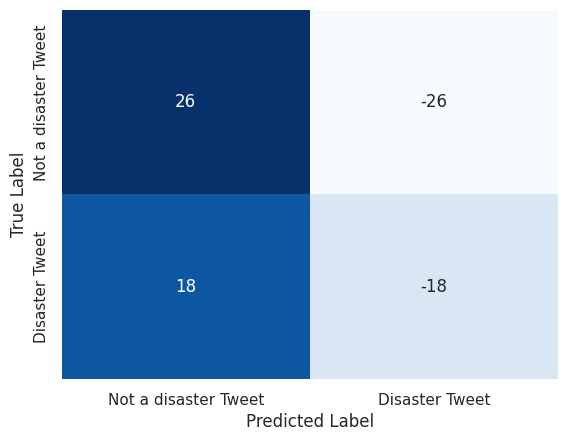

In [ ]:
# Generate V2's confusion matrix
v2_confusion_matrix = tf.math.confusion_matrix(Y_test, v2_val_preds)
diff_matrix = v1_confusion_matrix - v2_confusion_matrix
# Demonstrate the difference
ax = sns.heatmap(diff_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=labels, yticklabels=labels, cbar=False)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In a confusion matrix, the off-diagonal values represent incorrect predictions. Smaller values, in off-diagonal tiles, are indicative of more accurate models. Here, the largest difference occurs for disaster tweets classified as non disaster tweets, the false negatives, with a value of -26. Since we are taking the difference of V1's matrix from V2, this negative value indicates that V2 has a much higher number of false negatives. By doing the math, V2 has a total of 74 false negatives, almost 1.5 times the amount that V1 has, making it a considerably worse model. Additionally, the large positive 26, for the true negatives, indicates that V1 has a much higher rate of correct classifications over V2.


### Viewing Word Embeddings

Let's now examine word embeddings to get an idea of how the words correlated within the model. In order to get an understanding of how words were organized within the embedding, it is best to once again utilize our best model: V1.

In [ ]:
# View the layers for V1
display(ffnn_model.layers)

# Retrieve just the embeddings layer
embeddings = ffnn_model.layers[0].get_weights()[0]
print(embeddings.shape)

(10000, 128)


In [ ]:
def plot_embeddings(embeddings, start, num_words):
  # Get 1st and 2nd embeddings for the desired tokens
  x1 = embeddings[start:start+num_words, 0]
  x2 = embeddings[start:start+num_words, 1]

  # Get the specified words from our encoding to word dict
  words = [encode_to_words[i] for i in range(start, start+num_words)]

  # Plot 
  data = plotly.Scatter(x=x1, y=x2, text=words, mode='markers', 
                        textposition='bottom left', hoverinfo='text')
  
  fig = plotly.Figure(data=[data], layout=plotly.Layout(
                                           title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

# Plot just enough words for us to analyze
plot_embeddings(embeddings, 1000, 1000)

We can observe that nouns such as "cinema" and "residential" tend to be clustered near the center. On the extreme lower and upper quadrants, other non-related words to disasters are plotted. The word "arent" is plotted in the lower left quadrant while "palestinian" and "yyc" are plotted in the upper right quadrant. Additionally, we can observe that, in this same quadrant, related words such as "storm", "abstorm", and "powerlines" are grouped together. Furthering this point, the words "shot" and "battlefield" are close together around the middle.

From this, we can conclude that our model is succesfully grouping related words close together in our embedding space while keeping unrelated ones farther out in the extremes. It isn't a very telling indicator of whether Tweets are being classified correctly, but it does let us know that our model has correctly established associations between words in our vocabulary.

## Analyzing Errors

### Identifying Errors

In order to better understand in what areas V1 failed, let's identify potential sources of error by examining our model's predictions in contrast to the actual results.

In [ ]:
error_dict = {'Tweet': [], 'Model Predictions': [], 'Actual Predictions': []}
Y = Y_test['target'].tolist() # easier indexing
# Add desired values into dict
for i, tweet in enumerate(X_test['text'][:25]):
  # Only display discrepancies
  if Y[i] != v1_predictions[i]:
    # shorten tweet length for easier visualization
    error_dict['Tweet'].append(tweet[:50])  
    error_dict['Model Predictions'].append(v1_predictions[i])
    error_dict['Actual Predictions'].append(Y[i])

# Tabulate results
df = pd.DataFrame(error_dict)
print(df.to_string(index=False))

                                             Tweet  Model Predictions  Actual Predictions
                           @tsunami_esh ?? hey Esh                  1                   0
                #np agalloch - the desolation song                  1                   0
Hollywood Movie About Trapped Miners Released in C                  0                   1
The Catastrophic Effects of Hiroshima and Nagasaki                  0                   1
sorry-I built a fire by my desk already. RT@irishi                  1                   0
Witness video shows car explode behind burning bui                  0                   1
Sweetpea's are running riot at the allotment - and                  0                   1
After a violent afternoon storm more severe weathe                  0                   1
Everyday is a near death fatality for me on the ro                  1                   0
I just added 'Sandy First Responders Lost Their Ho                  0                   1


V1 classifies Tweets with the words "desolation", "fire", and "death" as natural disasters, despite this clearly not being the case. Tweets with the words "catastrophic", "trapped", "explode", and "storm" are not classified as natural disasters despite these words being strong indicators of that being the case. Let's examine how many times some of these words appear in the training data.

|Word|Frequency||
|-|-|-|
|desolation|71|
|fire|756|
|death|193|
|catastrophic|64|
|explode|149|
|storm|650|

By examining the Excel file for the training data and searching up the total number of occurrences for each of the previous words, we can generalize that the words the model classified as false positives were present in more Tweets than those classified as false negatives, on average. Since the model encounters these words more often, it is more likely to associate them with natural disasters.

### Addressing Errors 

Given the previous observations, we can conclude that our cleaning of the data was handled appropriately, given how most of the Tweets were preserved and the word embeddings clustered related words together. However, this model could be significantly improved by handling our vocabulary encoding in a completely different way.

With our observations in the previous section, we concluded that V1 favored words with higher frequencies. This is because we organized our vocabulary in a similar fashion. As a result, we subconsciously ignored an important point: words are not being encoded based on importance to the overall text. In other words, more neutral words such as "rum", with an ID of 6926, may end up of greater interest than intended to the model. Additionally, when cutting down on our vocabulary, we may unintentionally end up discarding useful keywords from it. Luckily, there exists a vocabulary vectorizer that overcomes these problems: TF-IDF.

TF-IDF stands for Term Frequency-Inverse Document Frequency and it refers to a process of encoding words in text by not only observing their frequency but also their importance in the text. It assigns each word a score calculated via a combination of their frequency and how often that word appears throughout the entire document being analyzed. A word's score increases by having a higher frequency while being lowered by appearing in more documents, hence the IDF term. This ensures that non-important words that appear constantly, such as "the", are assigned lower scores, which allows the models to focus on more relevant keywords. Based on each word's score, we can then make the decision of removing the bottom *n* lowest rated words from our vocabulary. In this way, we can safely remove words from our vocabulary that aren't too important instead of blindly discarding arbitrary words. By weighting words and considering their relevance in the text, it becomes a much better approach to word encoding than organizing words by frequency or randomly assigning them an ID. This reduces our model's complexity and allows it to focus on more indicative keywords.

A final way of improving upon our model is to switch out the underlying algorithm and instead build a Naive Bayes Classifier. Naive Bayes is a probabilistic classifier which assumes that each feature is independent of other features in the class. Each feature discovered contributes towards the final classification regardless of any possible correlations between other features. This would allow our model to weigh and consider each keyword individually, which could help in spotting correlations between keywords and a final classification more accurately. Additionally, it utilizes Bayes' Theorem which describes the probability of an event ocurring based on prior knowledge related to said event. By taking prior Tweets classified as disasters into consideration, along with the previous corrections, we could produce a vastly more accurate model. In being a probabilistic classifier commonly used in text classification and sentiment analysis, it could make up for our shortcomings and provide more accurate results than the models and methods applied here.